# Implement with R

## The Chemical Catalyst Experiment

This experiment aims to give a sense of **blocking** in factorial designs.

Suppose for the $n$ replicates, each set of non-homogeneous conditions logically fits into a "block", and each replicate is one run in one of the blocks (they are made in random order). Then we would want to implement blocking to control the variation between these "block"s. 

Consider the chemical process experiment described in previous chapter 5. If one batch of raw materials is enough for only `4` experimental trials ($A \times B$), then `3` batches of raw material will be required to run all replicates of this design.

<img src="Blocking.png" width="400" height="auto" />

(Source: [Montgomery, D. C., Custer, L. & McCarville, D. R., 2013, \"Design and analysis of experiments: Student solutions manual (8th ed.).\", Hoboken, NJ: John Wiley & Sons](https://www.amazon.com/Student-Solutions-Manual-Analysis-Experiments/dp/1118388194))


The idea is to find if blocking does help with controlling the variation between the different batches.

Firstly, import the dataset,

In [1]:
dataset <- read.csv('chem3.csv')

Display the table to get a sense of the data

In [2]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
install.packages('reshape2')

Installing package into ‘/usr/local/lib/R/4.1/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(reshape2)

In [4]:
dataset_tbl <- dataset %>% group_by(A, B, Block) %>% arrange(desc(A), desc(B), Block)
dataset_tbl <- dcast(dataset_tbl,A+B~Block, fill=0)
dataset_tbl$Total <- dataset_tbl$b1 + dataset_tbl$b2 + dataset_tbl$b3
dataset_tbl <- merge(dataset_tbl, read.csv('../2_2_vars.csv'))
dataset_tbl

Using Y as value column: use value.var to override.

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../2_2_vars.csv'”


A,B,b1,b2,b3,Total,Treatment
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
H,H,31,30,29,90,ab
H,L,36,32,32,100,a
L,H,18,19,23,60,b
L,L,28,25,27,80,1


In [6]:
t(dataset %>% group_by(Block) %>% summarise(Total=sum(Y)))

Block,b1,b2,b3
Total,113,106,111


In [7]:
sum(dataset$Y)

[1] 330

Using ANOVA with blocking,

In [8]:
anova <- aov(Y ~ A * B + Block, data=dataset)
summary(anova)

            Df Sum Sq Mean Sq F value   Pr(>F)    
A            1 208.33  208.33  50.336 0.000394 ***
B            1  75.00   75.00  18.121 0.005340 ** 
Block        2   6.50    3.25   0.785 0.497835    
A:B          1   8.33    8.33   2.013 0.205710    
Residuals    6  24.83    4.14                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Because the block p-value is greater than `0.05` (alpha level), there is not significance effect based on the batches (similar to previous design without blocking).

## 2-Blocks Confounding Experiment

This experiment aims to give a sense of **confounding** in $2^2$ factorial designs.

In many situations, it is usually infeasible to perform a complete replicate of a factorial design in one block. Hence, confounding is a design technique for arranging a complete factorial experiment in blocks, where the block size is smaller than the number of treatment combinations in one replicate. This causes information about certain treatment effects (usually high order interactions) to be indistinguishable from, or confounded with, blocks.

For example,

<img src="Confounding-1.png" width="300" height="auto" />

(Source: Chew Chee Hua. "Basic Statistical Methods in Experimental Design")

Firstly, import the dataset,

In [6]:
dataset <- read.csv('twoblocks.csv')

Display the table to get the sense of the data,

In [7]:
dataset_tbl <- dataset %>% group_by(A, B) %>% arrange(desc(A), desc(B))
dataset_tbl.Y <- dataset_tbl %>% summarise(Y=sum(Y))
dataset_tbl <- dcast(dataset_tbl, A+B~Scheme, fill=0, value.var="Block")
dataset_tbl$Y <- dataset_tbl.Y$Y
dataset_tbl <- merge(dataset_tbl, read.csv('../2_2_vars.csv'))
dataset_tbl

`summarise()` has grouped output by 'A'. You can override using the `.groups` argument.

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../2_2_vars.csv'”


A,B,s1,s2,s3,Y,Treatment
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
H,H,b2,b2,b2,90.9,ab
H,L,b1,b2,b1,90.1,a
L,H,b2,b1,b1,90.2,b
L,L,b1,b1,b2,90.4,1


Calculating the scheme 1 for block effect $b$,

$b = \frac{1}{2}(b_2 - b_1)$

$b = \frac{1}{2}(ab + b - a - 1)$

In [14]:
sumOfYTreatments <- function(vars) { sum(dataset_tbl[dataset_tbl$Treatment %in% vars,]$Y) }

In [16]:
sumOfYTreatments(c('b', 'ab')) / 2 - sumOfYTreatments(c('a', '1')) / 2

[1] 0.3

Calculating the scheme 2 for block effect $b$,

$b = \frac{1}{2}(ab + a - b - 1)$

In [17]:
sumOfYTreatments(c('a', 'ab')) / 2 - sumOfYTreatments(c('b', '1')) / 2

[1] 0.2

Calculating the scheme 3 for block effect $b$,

$b = \frac{1}{2}(ab + 1 - b - a)$

In [18]:
sumOfYTreatments(c('ab', '1')) / 2 - sumOfYTreatments(c('a', 'b')) / 2

[1] 0.5

Calculating the effects of $A$,

$A = \frac{1}{2}(ab + a - b - 1)$

This results in the same effect as blocking scheme 2. $A$ and $b$ are not distinguishable or confounded.

Calculating the effects of $B$,

$B = \frac{1}{2}(ab + b - a - 1)$

This results in the same effect as blocking scheme 1. $B$ and $b$ are not distinguishable or confounded.

Calculating the interaction effects of $AB$,

$AB = \frac{1}{2}(ab + 1 - a - b)$

This results in the same effect as blocking scheme 3. $AB$ and $b$ are not distinguishable or confounded.

The confounding is caused by the block arrangement matching the contrast of some factorial effect, and depending on the scheme chosen, confounding made the effect inestimable.

<img src="Confounding-0.png" width="400" height="auto" />

(Source: [Montgomery, D. C., Custer, L. & McCarville, D. R., 2013, \"Design and analysis of experiments: Student solutions manual (8th ed.).\", Hoboken, NJ: John Wiley & Sons](https://www.amazon.com/Student-Solutions-Manual-Analysis-Experiments/dp/1118388194))

The best scheme would be scheme 3. The standard practice is to confound the highest order interaction with blocks as it is relatively least likely to have an effect, hence the choice. 

## The Filtration Rate Experiment

This experiment aims to give a sense of **confounding** in  $2^4$ factorial designs.

Reconsider the filtration rate experiment described in previous chapter 5. Recall the 4 factors - temperature (**A**), pressure (**B**), concentration of formaldehyde (**C**) and stirring rate (**D**) are studied in a new plant to determine their effect on filtration rate.

We introduce a block effect so that the utility of blocking can be shown. Suppose that when we select the two batches of raw material required to run the expt, one of them is of much poorer quality level and, as a result, all responses will be, for the sake of convenience, `20` units lower in this material batch than in the other (e.g., notice for batch 1, **(1)** is `25` instead of `45` from the original experiment). The poor quality batch becomes block 1 and the good quality batch becomes block 2 (actually, it does not matter which batch is called block 1 or which batch is called block 2, as they are just labels). Again, the eight runs within the block are, of course, performed in random order.

Given that all the treatment combinations cannot be run using a batch of raw material, and the experimenter can only run `8` treatment combinations from a single batch of material, the design is confounded in two blocks appropriate in this case.

<img src="Confounding.png" width="450" height="auto" />

(Source: [Montgomery, D. C., Custer, L. & McCarville, D. R., 2013, \"Design and analysis of experiments: Student solutions manual (8th ed.).\", Hoboken, NJ: John Wiley & Sons](https://www.amazon.com/Student-Solutions-Manual-Analysis-Experiments/dp/1118388194))

Firstly, import dataset,

In [14]:
dataset <- read.csv('filtration.csv')

Display the table to get a sense of the data

In [15]:
dataset %>% arrange(Block, desc(A), desc(B), desc(C), desc(D))

A,B,C,D,Block,Y
<chr>,<chr>,<chr>,<chr>,<chr>,<int>
L,L,L,L,b1,25
L,L,H,H,b1,55
L,H,L,H,b1,25
L,H,H,L,b1,60
H,L,L,H,b1,80
H,L,H,L,b1,40
H,H,L,L,b1,45
H,H,H,H,b1,76
L,L,L,H,b2,43


In [16]:
dataset %>% group_by(Block) %>% summarise(Total=sum(Y))

Block,Total
<chr>,<int>
b1,406
b2,555


The block effect is calculated as such where $b_2 - b_1$,

In [17]:
b1 <- (dataset %>% filter(Block == "b1"))$Y
b2 <- (dataset %>% filter(Block == "b2"))$Y

sum(b2) / length(b2) - sum(b1) / length(b1)

[1] 18.625

Or calculated as $b_1 - b_2$, which is similar to the effect of $ABCD$,

In [18]:
sum(b1) / length(b1) - sum(b2) / length(b2)

[1] -18.625

In the previous experiment, the interaction effect $ABCD = 1.375$, and in the present example, the estimate is $ABCD = -18.625$. This can be calculated using $1.375 - 20 = -18.625$ (aka deducting the effect from a different batch), 

In this case, we ignore the higher-order interaction and confound the highest order interaction ABCD with two blocks as shown here as it is the most appropriate for the $2^4$ design.

## The Plasma Etching Experiment

This experiment aims to give a sense of **partial confounding** in  $2^3$ factorial designs.

Consider an experiment to optimise a plasma etching process, and there are 3 variables (**A**) gap, (**B**) gas flow, and (**C**) RF power, and the response variable is the etch rate. 

Suppose that only `4` treatment combinations can be tested during a shift timing, and because there could be shift-to-shift differences in etching tool performance, the experimenters decide to use shifts as a blocking variable. Thus, each replicate of the `23` design has to be run in `2` blocks.

The data are as follows:

<img src="PartialConfounding.png" width="400" height="auto" />

(Source: [Montgomery, D. C., Custer, L. & McCarville, D. R., 2013, \"Design and analysis of experiments: Student solutions manual (8th ed.).\", Hoboken, NJ: John Wiley & Sons](https://www.amazon.com/Student-Solutions-Manual-Analysis-Experiments/dp/1118388194))

Unless there is a prior estimate of error, or assumption of certain interactions to be negligible, we have to replicate the design to obtain an estimate of error. The previous examples are complete confounding design as certain interactions effects are completely confounded by the blocks.

If there are `4` of this design, different interaction is confounded in each replicate. For example, $ABC$ in replicate 1, $AB$ in replicate 2, $BC$ in replicate 3, $AC$ in replicate 4. As a result, information on $ABC$ can be obtained from the data not confounded in replicates 2, 3 and 4. Thus, `3/4` of information can be obtained on the interactions because they are unconfounded in `3/4` replicates.

Firstly, import dataset,

In [19]:
dataset <- read.csv('etch.csv')

In [20]:
dataset$A <- factor(dataset$A)
dataset$B <- factor(dataset$B)
dataset$C <- factor(dataset$C)
dataset$Replicate <- factor(dataset$Replicate)
dataset$Block <- factor(dataset$Block)

In [21]:
dataset_tbl <- dataset %>% group_by(A, B, C) %>% arrange(desc(A), desc(B), desc(C))
dataset_tbl$Block.Y <- paste(dataset_tbl$Block, dataset_tbl$Y, sep=" = ")
dataset_tbl <- dcast(dataset_tbl, A+B+C~Replicate, fun=function(x) { paste(x, collapse = " , ")}, fill='', value.var="Block.Y")
dataset_tbl <- merge(dataset_tbl, read.csv('../2_3_vars.csv'))
dataset_tbl

A,B,C,r1,r2,Treatment
<fct>,<fct>,<fct>,<chr>,<chr>,<chr>
H,H,H,b2 = 729,b1 = 860,abc
H,H,L,b1 = 642,b1 = 635,ab
H,L,H,b1 = 749,b2 = 868,ac
H,L,L,b2 = 669,b2 = 650,a
L,H,H,b1 = 1075,b2 = 1063,bc
L,H,L,b2 = 633,b2 = 601,b
L,L,H,b2 = 1037,b1 = 1052,c
L,L,L,b1 = 550,b1 = 604,1


For replicate 1, find the block effect,

$b_{r_1} = \frac{1}{2(2^3)}(abc + a + b + c - ab - ac - bc - 1)$

Notice this is similar to calculating the effect of $ABC$,

$ABC = \frac{1}{2(2^3)}(abc + a + b + c - ab - ac - bc - 1)$

Therefore, for replicate 1, the $ABC$ is confounded.

For replicate 2, find the block effect,

$b_{r_2} = \frac{1}{2(2^3)}(ac + a + bc + b - abc - ab - c - 1)$

Since we could not find a matching effect, we swap it,

$b_{r_2} = \frac{1}{2(2^3)}(1 + c + ab + abc - a - bc - b - ac)$

Notice this is similar to calculating the effect of $AB$,

$AB = \frac{1}{2(2^3)}(1 + c + ab + abc - a - bc - b - ac)$

Therefore, for replicate 2, the $AB$ is confounded.

Displaying the ANOVA with blocking and replicates,

In [48]:
anova <- aov(lm(Y ~ A * B * C + Replicate + Block%in%Replicate, data=dataset))
summary(anova)

                Df Sum Sq Mean Sq F value   Pr(>F)    
A                1  41311   41311  16.194  0.01008 *  
B                1    218     218   0.085  0.78199    
C                1 374850  374850 146.945 6.75e-05 ***
Replicate        1   3875    3875   1.519  0.27255    
A:B              1   2475    2475   0.970  0.36985    
A:C              1  94403   94403  37.007  0.00174 ** 
B:C              1     18      18   0.007  0.93621    
Replicate:Block  2   1511     756   0.296  0.75586    
A:B:C            1      6       6   0.002  0.96282    
Residuals        5  12755    2551                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

# Formative Questions

(Source: Chew Chee Hua. "Basic Statistical Methods in Experimental Design")

## Question 1

An experiment was performed to improve the yield of a chemical process. `4` variables were selected, and `2` replicates of a completely randomised expt were run. Estimate the variable effects.

## Question 2

Prepare an analysis of variance table and determine which variables are important in explaining yield.

In [26]:
dataset <- read.csv('chem4.csv')

In [27]:
dataset$A <- as.factor(dataset$A)
dataset$B <- as.factor(dataset$B)
dataset$C <- as.factor(dataset$C)
dataset$D <- as.factor(dataset$D)

In [30]:
dataset_tbl <- dataset %>% group_by(A, B, C, D) %>% summarise(Total=sum(Y))
dataset_tbl <- merge(dataset_tbl, read.csv('../2_4_vars.csv'))

yates <- read.csv('../2_4_yates.csv')
yates_t <- merge(yates, dataset_tbl[c('Total', 'Treatment')])

effects <- colSums(yates_t[!(names(yates_t) %in% c('Treatment', 'Total'))] * (1/(2^(4-1) * 2)) * yates_t$Total)
t(effects)

`summarise()` has grouped output by 'A', 'B', 'C'. You can override using the `.groups` argument.



A,B,AB,C,AC,BC,ABC,D,AD,BD,ABD,CD,ACD,BCD,ABCD
-9.0625,-1.3125,4.0625,-2.6875,0.6875,-0.5625,-5.1875,3.9375,-2.1875,-0.1875,4.6875,1.6875,-0.9375,-0.9375,2.4375


In [31]:
anova <- aov(Y ~ A*B*C*D, data=dataset)
summary(anova)

            Df Sum Sq Mean Sq F value   Pr(>F)    
A            1  657.0   657.0  85.816 7.87e-08 ***
B            1   13.8    13.8   1.800 0.198445    
C            1   57.8    57.8   7.547 0.014317 *  
D            1  124.0   124.0  16.200 0.000979 ***
A:B          1  132.0   132.0  17.245 0.000749 ***
A:C          1    3.8     3.8   0.494 0.492302    
B:C          1    2.5     2.5   0.331 0.573296    
A:D          1   38.3    38.3   5.000 0.039945 *  
B:D          1    0.3     0.3   0.037 0.850417    
C:D          1   22.8    22.8   2.976 0.103793    
A:B:C        1  215.3   215.3  28.118 7.15e-05 ***
A:B:D        1  175.8   175.8  22.959 0.000200 ***
A:C:D        1    7.0     7.0   0.918 0.352162    
B:C:D        1    7.0     7.0   0.918 0.352162    
A:B:C:D      1   47.5    47.5   6.208 0.024077 *  
Residuals   16  122.5     7.7                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

The significant factors are $A$, $C$, $D$, $AB$, $ABC$, $AD$, $ABD$ and $ABCD$. 

## Question 3

Write down a regression model for predicting yield, assuming that all four variables were varied over the range from `−1` to `+1` (in coded units).

## Question 4

Plot the residuals versus the predicted yield and on a normal probability scale. Does the residual analysis appear satisfactory?

In [8]:
dataset <- read.csv('chem4_num.csv')

In [10]:
lr <- lm(Y ~ A + C + D + I(A*B) + I(A*D) + I(A*B*C) + I(A*B*D) + I(A*B*C*D), data=dataset)
summary(lr)


Call:
lm(formula = Y ~ A + C + D + I(A * B) + I(A * D) + I(A * B * 
    C) + I(A * B * D) + I(A * B * C * D), data = dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.0312 -1.8125 -0.1875  0.9844  6.9687 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       82.7812     0.4941 167.523  < 2e-16 ***
A                 -4.5312     0.4941  -9.170 3.82e-09 ***
C                 -1.3437     0.4941  -2.719 0.012230 *  
D                  1.9688     0.4941   3.984 0.000585 ***
I(A * B)           2.0312     0.4941   4.111 0.000427 ***
I(A * D)          -1.0938     0.4941  -2.213 0.037065 *  
I(A * B * C)      -2.5937     0.4941  -5.249 2.52e-05 ***
I(A * B * D)       2.3438     0.4941   4.743 8.83e-05 ***
I(A * B * C * D)   1.2187     0.4941   2.466 0.021530 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.795 on 23 degrees of freedom
Multiple R-squared:  0.8896,	Adjusted R-squared:  0.8512 
F-

hat values (leverages) are all = 0.28125
 and there are no factor predictors; no plot no. 5



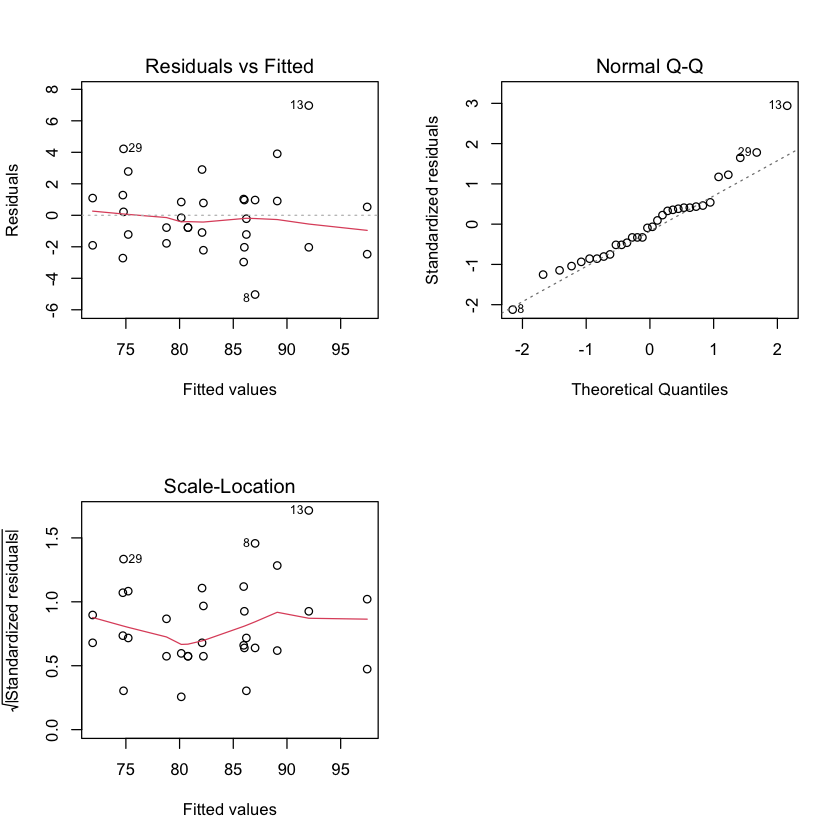

In [11]:
par(mfrow=c(2,2))
plot(lr)

There are no reasons to question its normality as there no obvious problem with model assumptions.

## Question 5
Consider only the data from the first replicate. Construct a design with two blocks of eight observations each with $ABCD$ confounded. Analyse the data.

In [ ]:
dataset <- read.csv('chem4abcd.csv')
anova <- aov(Y ~ A * B * C * D + Block, data=dataset)
summary(anova)

Insufficient data points for ANOVA p-values. We will select the factors with relatively high mean squared as they are likely to be significant: $A$, $D$, $ABC$. However since $B$ and $C$ is not selected, therefore we will not use $ABC$, and block effect is confounded with $ABCD$ by design (see "Block").

In [ ]:
anova <- aov(Y ~ A + D, data=dataset)
summary(anova)

Only factor $A$ is significant.